## Image Processing and Classification

In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

#### To reduce the Python dependencies to a minimum we have save a Modis satellite image to disk using a numpy specific format. We can load this file into a numpy array by doing:

In [2]:
arr_modis = np.load("data/modis_cube.npz")["nadir"]

arr_modis.shape

(2400, 2400, 7)

#### This file contains a composite image taken by the MODIS Terra and Acqua satellites over 8 days. The image correspond to the area of southwest France and north of Spain around mid July 2018. Each pixel has a resolution of 500 meters and there are 7 spectral bands. The first four bands correspond to the following products respectively: `[red, near infra-red (nir), blue, green]`

#### Let's plot one its bands to have quick look at the region:

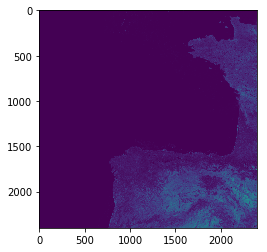

In [19]:
plt.imshow(arr_modis[:,:,0])

#### The MODIS data is provided as digital numbers (or DNs).  We can see the array contains 2-byte integers - meaning these are 16-bit numbers that can be both positive and negative. 

#### Before we can interpret these images we would need to convert these values into reflectance values. Reflectance is a measure that indicates the proportion of the energy at each part of the spectrum that is reflected by the Earth at each spectral band.  To do this conversion have to use a conversion factor of 1e4 (if you are not familiar with that notation: 1e4 means 1*10^4, i.e. 10000)

#### To scale the values into reflectance values we can perform this operation which applies the division along the whole array element-wise:

In [20]:
refl_modis = arr_modis / 1e4

print(arr_modis.min(), arr_modis.max())
print(arr_modis.dtype)
print(refl_modis.min(), refl_modis.max())
print(refl_modis.dtype)

0 753
int16
0.0 0.0753
float64


#### As we can see numpy automatically converts the values in the array from integers into floats to performs the division.

#### Let's create a true colour composite, that is a Red-Green-Blue composite like the photo of Black Mountain, but now constructed from the corresponding red, green and blue bands of the MODIS image. This is done in the following three lines of code. 

#### To do this, we need to scale the values to byte numbers in the [0-255]. Let's see how we can do this with numpy:

In [22]:
refl_modis = refl_modis / refl_modis.max()

refl_modis.min(), refl_modis.max()

(0.0, 1.0)

#### What we have done is to scale the values between 0 and 255 and then convert the contents of the array into the type `1 byte unsigned integer` which is what we need to show RGB images with matplotlib.

#### Now we use the `imshow` to display the RGB channels from our array selecting the channels [0, 3, 2], which correspond to the red, green and blue spectral bands in MODIS:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


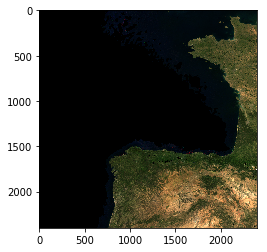

In [23]:
#Notice the *3 multiplier that we use to increase the values in these bands resulting in a brighter image

plt.imshow(refl_modis[:,:,[0,3,2]]*3)

#### Similarly, we can create different combination of bands mapping different spectral bands to the red, green and blue channels of an image. This is called false colour images.

#### For example, if we map the near infrared (nir) channel to the red colour we get this images with bright red in the regions with more vegetation. Different combinations of reflectance bands are used to look at different properties of the land surface.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


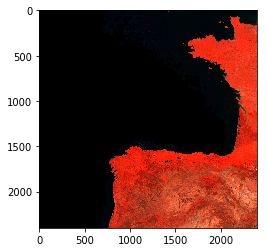

In [24]:
plt.imshow(refl_modis[:,:,[1,3,2]]*2)

#### While false colour composites can be visually useful ways of showing satellite imagery, there are distinct advantages in calculating a single index that captures the feature you are interested in. One such index is the Normalised Difference Vegetation Index (NDVI) which helps show living vegetation (see theory).

## NDVI=(NIR-Red)/(NIR+Red)

#### This operation can be performed in numpy using a very similar notation using arrays:

/Users/pablo/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


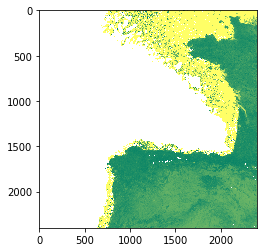

In [25]:
ndvi_modis = (refl_modis[:,:,1]-refl_modis[:,:,0]) / (refl_modis[:,:,1]+refl_modis[:,:,0])

#To make vegetation look green in the image we apply a colour palette that goes from yellow to green.
plt.imshow(ndvi_modis, cmap='summer_r')

#### We can adjust how the values are mapped into the colours in the palette by providing the maximum and minimum values to the `imshow` function. For example:

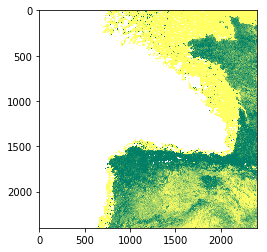

In [26]:
plt.imshow(ndvi_modis, vmin=.2, vmax=.8, cmap='summer_r')

#### Exercise: Can you create a false colour RGB image using the following mapping: R->red, G->nir, B->blue. Once you have a green fluo image zoom into a region using your indexing skills to select a range of values in the x and y axis.

#### The MODIS data is multi-spectral. We also have some hyperspectral imagery covering the ANU, collected from an airplane in February 2014. High-resolution hyper-spectral data tends to make for very large files. To make processing in this lab easier, we have packed a numpy array with the just the red, nir, green and blue bands. This array is 3-dimensional and the third dimension contains the information of one band of the hyperspectral data, just like the MODIS data. Let's load the data.

##### Notice that this array also needs to be converted first to reflectance values dividing it by 1e4

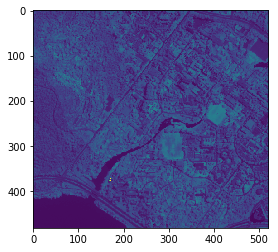

In [3]:
arr_anu = np.load("data/anu_cube.npz")["array"]
refl_anu = arr_anu/1e4
plt.imshow(refl_anu[:,:,1])

#### Exercise: Can you calculate the NDVI index for this image following similar steps to the MODIS example? 

In [ ]:
ndvi_anu = None

#Your code here

plt.imshow(ndvi_anu, cmap='summer_r')

#### Similarly to NDVI there is another index called Green Colour Coordinate (GCC), which is an alternative method to NDVI to look at how green the vegetation is and is not based on the near infrared band.

/Users/pablo/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


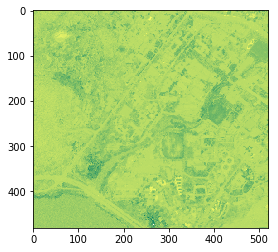

In [30]:
gcc_anu = refl_anu[:,:,2]/(refl_anu[:,:,0]+refl_anu[:,:,2]+refl_anu[:,:,3])

plt.imshow(gcc_anu, cmap='summer_r')

#### Let's do some classification and use that to create a new false colour composite showing three classification categories. We will assume that:

* Class 1: NDVI equal or greater than 0.5 and GCC greater than 0.4 indicates green, vegetated surfaces; we will colour the corresponding pixels red (by giving the red band of the false colour composite the DN 255, and the other bands DN 0).
* Class 2: NDVI less than 0.5 and GCC greater than 0.4 indicates surfaces that look green but are not vegetated; we will colour those green.
* Class 3: NDVI more than 0.5 and GCC less or equal than 0.4 indicates vegetated surfaces that don't look green; we will colour those pixels blue.

##### To apply this we write the above as logical statements, and use the results to create a false colour composite.

/Users/pablo/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.
/Users/pablo/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/Users/pablo/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/Users/pablo/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/Users/pablo/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/pablo/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less_equal
  This is separate f

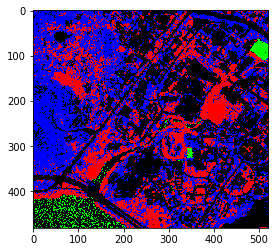

In [46]:
c1 = np.logical_and(ndvi_anu>=0.5, gcc_anu>0.4)
c2 = np.logical_and(ndvi_anu<0.5, gcc_anu>0.4)
c3 = np.logical_and(ndvi_anu>=0.5, gcc_anu<=0.4)

#We use this numpy function to stack 2-dimensional arrays over the 3rd axis or depth:
class_comp = np.dstack((c1,c2,c3)).astype(np.uint8) * 255

plt.imshow(class_comp)

#### You will see this leaves a fourth class in the image, of pixels that fall in none of the three classes. They show up in black. There are two surfaces that show up 'green' and one area that shows mixed  black and blue bits. What are they?

#### This simple classification uses index thresholds, which is a crude but  sometimes useful way of classifying images. In this case, it helps to finding unvegetated green surfaces, such as tennis courts and artificial grass. It is also clear that greenish water confounds the classification, however. 